In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading and preprocessing data...
Original Cardio Data Count: 70000
Original Heart Data Count: 1025
Original Cardio Data:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  

Original Heart Data:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155   

<Figure size 640x480 with 0 Axes>

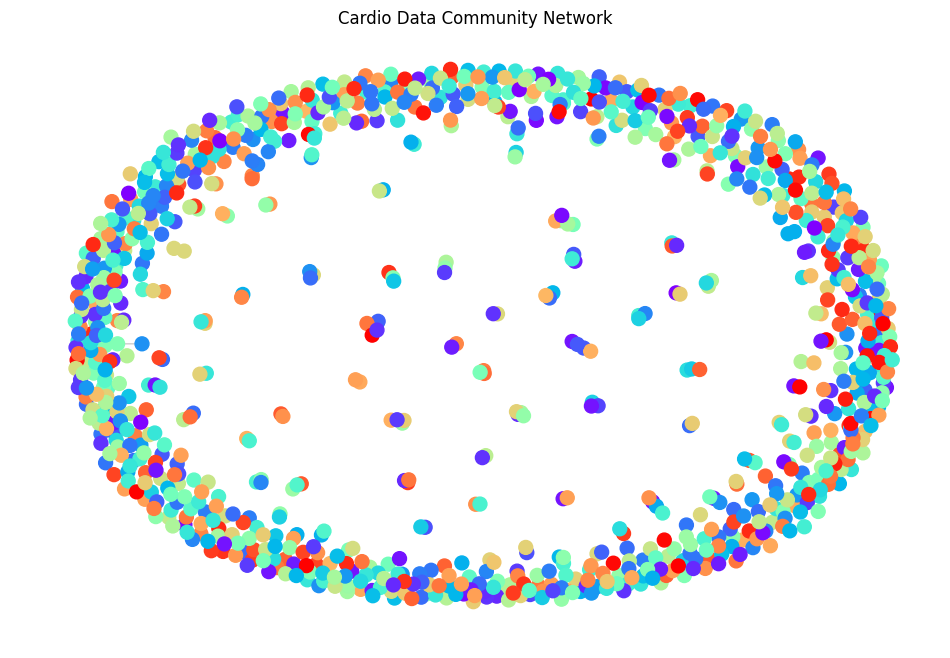

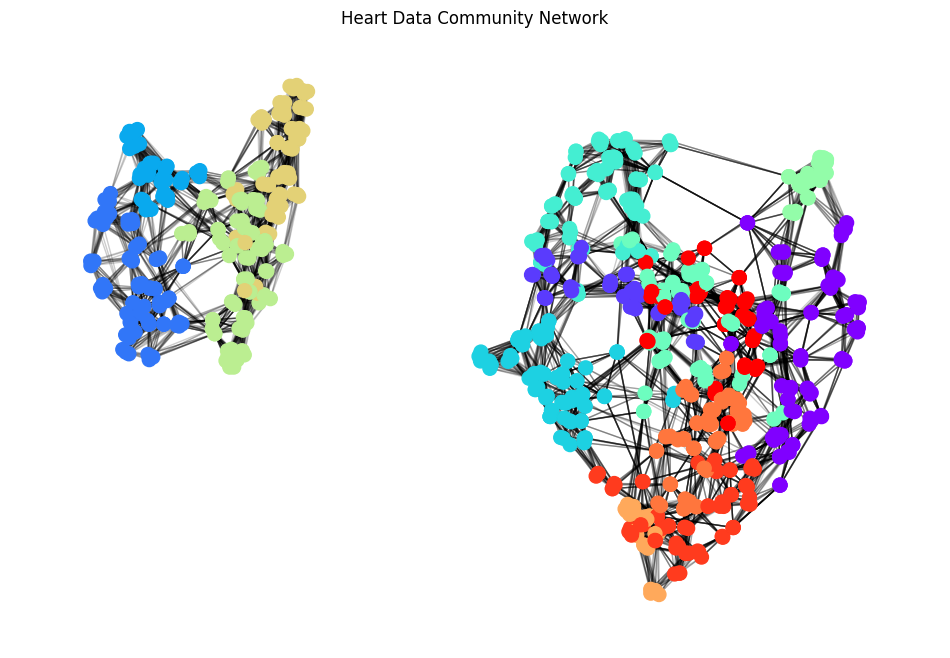

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import normalized_mutual_info_score, f1_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.sparse import csr_matrix

def load_and_preprocess():
    # Load datasets
    cardio_df = pd.read_csv('/content/drive/MyDrive/AJS/cardio_train.csv', sep=';')
    heart_df = pd.read_csv('/content/drive/MyDrive/AJS/heart.csv')

    # Display original data counts
    print("Original Cardio Data Count:", len(cardio_df))
    print("Original Heart Data Count:", len(heart_df))

    # Display original data
    print("Original Cardio Data:")
    print(cardio_df.head())
    print("\nOriginal Heart Data:")
    print(heart_df.head())

    # Fix gender values in cardio data
    cardio_df['gender'] = cardio_df['gender'].replace({1: 0, 2: 1})

    # Remove outliers using IQR method
    def remove_outliers(df, features):
        for feature in features:
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
        return df

    # Normalize age values in cardio data to years, accounting for leap years
    cardio_df['age'] = cardio_df['age'] / 365.25  # Convert days to years

    # Calculate BMI
    cardio_df['BMI'] = cardio_df['weight'] / ((cardio_df['height'] / 100) ** 2)

    cardio_features_for_outliers = ['age', 'BMI', 'ap_hi', 'ap_lo']
    heart_features_for_outliers = ['age', 'trestbps', 'chol', 'thalach']

    cardio_df = remove_outliers(cardio_df, cardio_features_for_outliers)
    heart_df = remove_outliers(heart_df, heart_features_for_outliers)

    # Drop height and weight columns
    cardio_df.drop(columns=['height', 'weight'], inplace=True)

    # Display data counts after cleaning
    print("\nCardio Data Count After Cleaning:", len(cardio_df))
    print("Heart Data Count After Cleaning:", len(heart_df))

    # Display data after cleaning
    print("\nCardio Data After Cleaning:")
    print(cardio_df.head())
    print("\nHeart Data After Cleaning:")
    print(heart_df.head())

    # Select relevant features for network creation
    cardio_features = ['age', 'gender', 'BMI', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
    heart_features = ['age', 'sex', 'trestbps', 'chol', 'thalach']

    # Standardize the features
    scaler = StandardScaler()
    cardio_scaled = scaler.fit_transform(cardio_df[cardio_features])
    heart_scaled = scaler.fit_transform(heart_df[heart_features])

    # Display feature statistics after cleaning
    print("\nFeature Statistics After Cleaning (Cardio):")
    print(cardio_df[cardio_features].describe())
    print("\nFeature Statistics After Cleaning (Heart):")
    print(heart_df[heart_features].describe())

    return cardio_scaled, heart_scaled, cardio_df, heart_df

def create_similarity_network(data, n_neighbors=10):
    """
    Create network using k-nearest neighbors for memory efficiency
    """
    # Create sparse similarity matrix using k-nearest neighbors
    A_knn = kneighbors_graph(data, n_neighbors=n_neighbors, mode='distance', include_self=False)

    # Convert distances to similarities
    A_knn.data = np.exp(-A_knn.data)

    # Make the matrix symmetric
    A_symmetric = 0.5 * (A_knn + A_knn.T)

    # Create networkx graph from sparse matrix
    G = nx.from_scipy_sparse_array(A_symmetric)

    return G

def detect_communities(G):
    try:
        import community.community_louvain as community
    except ImportError:
        print("Please install python-louvain package: pip install python-louvain")
        return None

    communities = community.best_partition(G)
    return communities

def visualize_network(G, communities, max_nodes=1000):
    """
    Visualize network with option to sample for large networks
    """
    if len(G) > max_nodes:
        # Sample nodes for visualization
        nodes = list(G.nodes())
        sampled_nodes = np.random.choice(nodes, max_nodes, replace=False)
        G_sample = G.subgraph(sampled_nodes)
        communities_sample = {node: communities[node] for node in sampled_nodes}
    else:
        G_sample = G
        communities_sample = communities

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G_sample)
    nx.draw_networkx_nodes(G_sample, pos,
                          node_color=list(communities_sample.values()),
                          cmap=plt.cm.rainbow,
                          node_size=100)
    nx.draw_networkx_edges(G_sample, pos, alpha=0.2)
    plt.title(f"Healthcare Data Community Network (showing {len(G_sample)} nodes)")
    plt.axis('off')
    return plt

def calculate_purity(true_labels, predicted_labels):
    contingency = contingency_matrix(true_labels, predicted_labels)
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

def calculate_nmi(true_labels, predicted_labels):
    return normalized_mutual_info_score(true_labels, predicted_labels)

def calculate_f_measure(true_labels, predicted_labels):
    unique_true = np.unique(true_labels)
    f1_scores = []

    for label in unique_true:
        true_binary = (true_labels == label).astype(int)
        pred_binary = (predicted_labels == label).astype(int)
        f1_scores.append(f1_score(true_binary, pred_binary))

    return np.mean(f1_scores)

def evaluate_communities(communities, true_labels):
    predicted_labels = list(communities.values())

    metrics = {
        'purity': calculate_purity(true_labels, predicted_labels),
        'nmi': calculate_nmi(true_labels, predicted_labels),
        'f_measure': calculate_f_measure(true_labels, predicted_labels)
    }

    return metrics

def analyze_communities(G, communities, df, features):
    n_communities = len(set(communities.values()))

    community_stats = {}
    for community_id in range(n_communities):
        nodes = [node for node in communities.keys()
                if communities[node] == community_id]

        subgraph = G.subgraph(nodes)
        sub_df = df.iloc[nodes]

        community_stats[community_id] = {
            'size': len(nodes),
            'density': nx.density(subgraph),
            'avg_degree': sum(dict(G.degree(nodes)).values()) / len(nodes)
        }

        for feature in features:
            community_stats[community_id][f'avg_{feature}'] = sub_df[feature].mean()

    return community_stats

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    cardio_scaled, heart_scaled, cardio_df, heart_df = load_and_preprocess()

    # Create networks
    print("Creating networks...")
    cardio_network = create_similarity_network(cardio_scaled, n_neighbors=20)
    heart_network = create_similarity_network(heart_scaled, n_neighbors=20)

    # Detect communities
    print("Detecting communities...")
    cardio_communities = detect_communities(cardio_network)
    heart_communities = detect_communities(heart_network)

    # Evaluate communities
    print("Evaluating communities...")
    cardio_metrics = evaluate_communities(cardio_communities, cardio_df['cardio'])
    heart_metrics = evaluate_communities(heart_communities, heart_df['target'])

    # Visualize networks
    print("Visualizing networks...")
    plt.figure(1)
    visualize_network(cardio_network, cardio_communities)
    plt.title("Cardio Data Community Network")

    plt.figure(2)
    visualize_network(heart_network, heart_communities)
    plt.title("Heart Data Community Network")

    # Analyze communities
    print("Analyzing communities...")
    cardio_features = ['age', 'gender', 'BMI', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
    heart_features = ['age', 'sex', 'trestbps', 'chol', 'thalach']
    cardio_stats = analyze_communities(cardio_network, cardio_communities, cardio_df, cardio_features)
    heart_stats = analyze_communities(heart_network, heart_communities, heart_df, heart_features)

    # Display network statistics
    print("\nNetwork Statistics (Cardio):")
    print(f"Number of nodes: {cardio_network.number_of_nodes()}")
    print(f"Number of edges: {cardio_network.number_of_edges()}")
    print(f"Density: {nx.density(cardio_network)}")

    print("\nNetwork Statistics (Heart):")
    print(f"Number of nodes: {heart_network.number_of_nodes()}")
    print(f"Number of edges: {heart_network.number_of_edges()}")
    print(f"Density: {nx.density(heart_network)}")

    return cardio_stats, heart_stats, cardio_metrics, heart_metrics

if __name__ == "__main__":
    cardio_stats, heart_stats, cardio_metrics, heart_metrics = main()

    print("\nCardio Community Statistics:")
    print(pd.DataFrame(cardio_stats).T)
    print("\nCardio Evaluation Metrics:")
    print(pd.DataFrame([cardio_metrics]))

    print("\nHeart Community Statistics:")
    print(pd.DataFrame(heart_stats).T)
    print("\nHeart Evaluation Metrics:")
    print(pd.DataFrame([heart_metrics]))

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import normalized_mutual_info_score, f1_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.sparse import csr_matrix
import community as community_louvain

def load_and_preprocess():
    # Load datasets
    cardio_df = pd.read_csv('/content/drive/MyDrive/AJS/cardio_train.csv', sep=';')
    heart_df = pd.read_csv('/content/drive/MyDrive/AJS/heart.csv')

    # Display original data counts
    print("Original Cardio Data Count:", len(cardio_df))
    print("Original Heart Data Count:", len(heart_df))

    # Display original data
    print("Original Cardio Data:")
    print(cardio_df.head())
    print("\nOriginal Heart Data:")
    print(heart_df.head())

    # Fix gender values in cardio data
    cardio_df['gender'] = cardio_df['gender'].replace({1: 0, 2: 1})

    # Remove outliers using IQR method
    def remove_outliers(df, features):
        for feature in features:
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
        return df

    # Normalize age values in cardio data to years, accounting for leap years
    cardio_df['age'] = cardio_df['age'] / 365.25  # Convert days to years

    # Calculate BMI
    cardio_df['BMI'] = cardio_df['weight'] / ((cardio_df['height'] / 100) ** 2)

    cardio_features_for_outliers = ['age', 'BMI', 'ap_hi', 'ap_lo']
    heart_features_for_outliers = ['age', 'trestbps', 'chol', 'thalach']

    cardio_df = remove_outliers(cardio_df, cardio_features_for_outliers)
    heart_df = remove_outliers(heart_df, heart_features_for_outliers)

    # Drop height and weight columns
    cardio_df.drop(columns=['height', 'weight'], inplace=True)

    # Display data counts after cleaning
    print("\nCardio Data Count After Cleaning:", len(cardio_df))
    print("Heart Data Count After Cleaning:", len(heart_df))

    # Display data after cleaning
    print("\nCardio Data After Cleaning:")
    print(cardio_df.head())
    print("\nHeart Data After Cleaning:")
    print(heart_df.head())

    # Select relevant features for network creation
    cardio_features = ['age', 'gender', 'BMI', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
    heart_features = ['age', 'sex', 'trestbps', 'chol', 'thalach']

    # Standardize the features
    scaler = StandardScaler()
    cardio_scaled = scaler.fit_transform(cardio_df[cardio_features])
    heart_scaled = scaler.fit_transform(heart_df[heart_features])

    # Display feature statistics after cleaning
    print("\nFeature Statistics After Cleaning (Cardio):")
    print(cardio_df[cardio_features].describe())
    print("\nFeature Statistics After Cleaning (Heart):")
    print(heart_df[heart_features].describe())

    return cardio_scaled, heart_scaled, cardio_df, heart_df

def create_similarity_network(data, n_neighbors=10):
    """
    Create network using k-nearest neighbors for memory efficiency
    """
    # Create sparse similarity matrix using k-nearest neighbors
    A_knn = kneighbors_graph(data, n_neighbors=n_neighbors, mode='distance', include_self=False)

    # Convert distances to similarities
    A_knn.data = np.exp(-A_knn.data)

    # Make the matrix symmetric
    A_symmetric = 0.5 * (A_knn + A_knn.T)

    # Create networkx graph from sparse matrix
    G = nx.from_scipy_sparse_array(A_symmetric)

    return G

def detect_communities(G):
    try:
        import community.community_louvain as community
    except ImportError:
        print("Please install python-louvain package: pip install python-louvain")
        return None

    communities = community.best_partition(G)
    return communities

def save_network_with_communities(G, communities, file_path, format='gexf'):
    # Add community attribute to each node
    for node, community in communities.items():
        G.nodes[node]['community'] = community

    # Save the network to the specified format
    if format == 'gexf':
        nx.write_gexf(G, file_path)
    elif format == 'gml':
        nx.write_gml(G, file_path)
    else:
        raise ValueError("Unsupported format. Choose 'gexf' or 'gml'.")

def calculate_purity(true_labels, predicted_labels):
    contingency = contingency_matrix(true_labels, predicted_labels)
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

def calculate_nmi(true_labels, predicted_labels):
    return normalized_mutual_info_score(true_labels, predicted_labels)

def calculate_f_measure(true_labels, predicted_labels):
    unique_true = np.unique(true_labels)
    f1_scores = []

    for label in unique_true:
        true_binary = (true_labels == label).astype(int)
        pred_binary = (predicted_labels == label).astype(int)
        f1_scores.append(f1_score(true_binary, pred_binary))

    return np.mean(f1_scores)

def evaluate_communities(communities, true_labels):
    predicted_labels = list(communities.values())

    metrics = {
        'purity': calculate_purity(true_labels, predicted_labels),
        'nmi': calculate_nmi(true_labels, predicted_labels),
        'f_measure': calculate_f_measure(true_labels, predicted_labels)
    }

    return metrics

def analyze_communities(G, communities, df, features):
    n_communities = len(set(communities.values()))

    community_stats = {}
    for community_id in range(n_communities):
        nodes = [node for node in communities.keys()
                if communities[node] == community_id]

        subgraph = G.subgraph(nodes)
        sub_df = df.iloc[nodes]

        community_stats[community_id] = {
            'size': len(nodes),
            'density': nx.density(subgraph),
            'avg_degree': sum(dict(G.degree(nodes)).values()) / len(nodes)
        }

        for feature in features:
            community_stats[community_id][f'avg_{feature}'] = sub_df[feature].mean()

    return community_stats

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    cardio_scaled, heart_scaled, cardio_df, heart_df = load_and_preprocess()

    # Create networks
    print("Creating networks...")
    cardio_network = create_similarity_network(cardio_scaled, n_neighbors=20)
    heart_network = create_similarity_network(heart_scaled, n_neighbors=20)

    # Detect communities
    print("Detecting communities...")
    cardio_communities = detect_communities(cardio_network)
    heart_communities = detect_communities(heart_network)

    # Evaluate communities
    print("Evaluating communities...")
    cardio_metrics = evaluate_communities(cardio_communities, cardio_df['cardio'])
    heart_metrics = evaluate_communities(heart_communities, heart_df['target'])

    # Save networks with communities
    print("Saving networks with communities...")
    save_network_with_communities(cardio_network, cardio_communities, 'cardio_network_with_communities.gexf', format='gexf')
    save_network_with_communities(heart_network, heart_communities, 'heart_network_with_communities.gexf', format='gexf')

    # Analyze communities
    print("Analyzing communities...")
    cardio_features = ['age', 'gender', 'BMI', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
    heart_features = ['age', 'sex', 'trestbps', 'chol', 'thalach']
    cardio_stats = analyze_communities(cardio_network, cardio_communities, cardio_df, cardio_features)
    heart_stats = analyze_communities(heart_network, heart_communities, heart_df, heart_features)

    # Display network statistics
    print("\nNetwork Statistics (Cardio):")
    print(f"Number of nodes: {cardio_network.number_of_nodes()}")
    print(f"Number of edges: {cardio_network.number_of_edges()}")
    print(f"Density: {nx.density(cardio_network)}")

    print("\nNetwork Statistics (Heart):")
    print(f"Number of nodes: {heart_network.number_of_nodes()}")
    print(f"Number of edges: {heart_network.number_of_edges()}")
    print(f"Density: {nx.density(heart_network)}")

    return cardio_stats, heart_stats, cardio_metrics, heart_metrics

if __name__ == "__main__":
    cardio_stats, heart_stats, cardio_metrics, heart_metrics = main()

    print("\nCardio Community Statistics:")
    print(pd.DataFrame(cardio_stats).T)
    print("\nCardio Evaluation Metrics:")
    print(pd.DataFrame([cardio_metrics]))

    print("\nHeart Community Statistics:")
    print(pd.DataFrame(heart_stats).T)
    print("\nHeart Evaluation Metrics:")
    print(pd.DataFrame([heart_metrics]))

Loading and preprocessing data...
Original Cardio Data Count: 70000
Original Heart Data Count: 1025
Original Cardio Data:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  

Original Heart Data:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155   

Loading and preprocessing data...
Original Cardio Data Count: 70000
Original Heart Data Count: 1025
Fine-tuning K-Means...
Evaluating clustering results...

Cardio Evaluation Metrics:
     purity       nmi  f_measure
0  0.701873  0.133475   0.286112
Best Cardio K-Means Params: {'n_clusters': 2}

Heart Evaluation Metrics:
     purity       nmi  f_measure
0  0.651282  0.070917   0.650832
Best Heart K-Means Params: {'n_clusters': 2}

Creating visualizations...


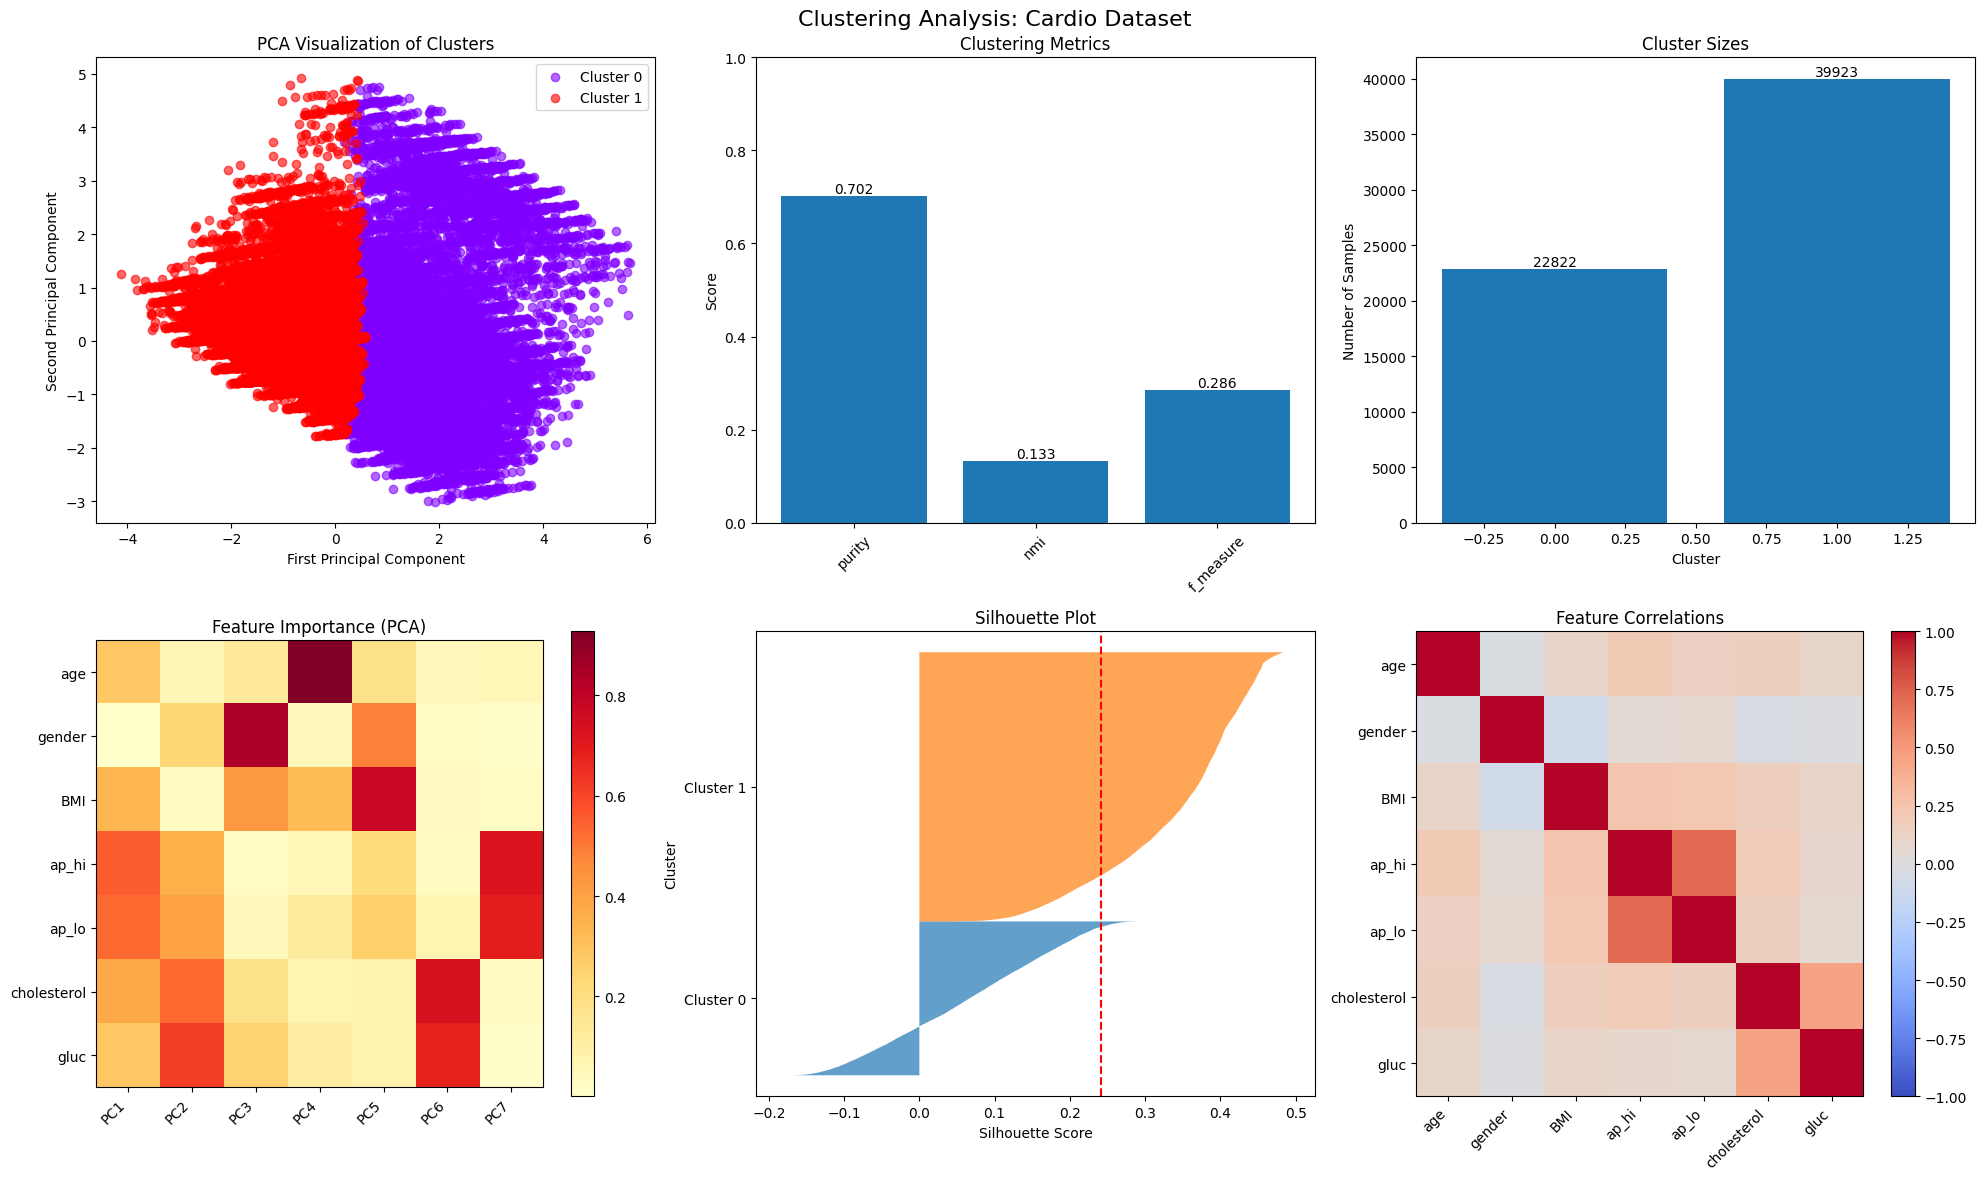

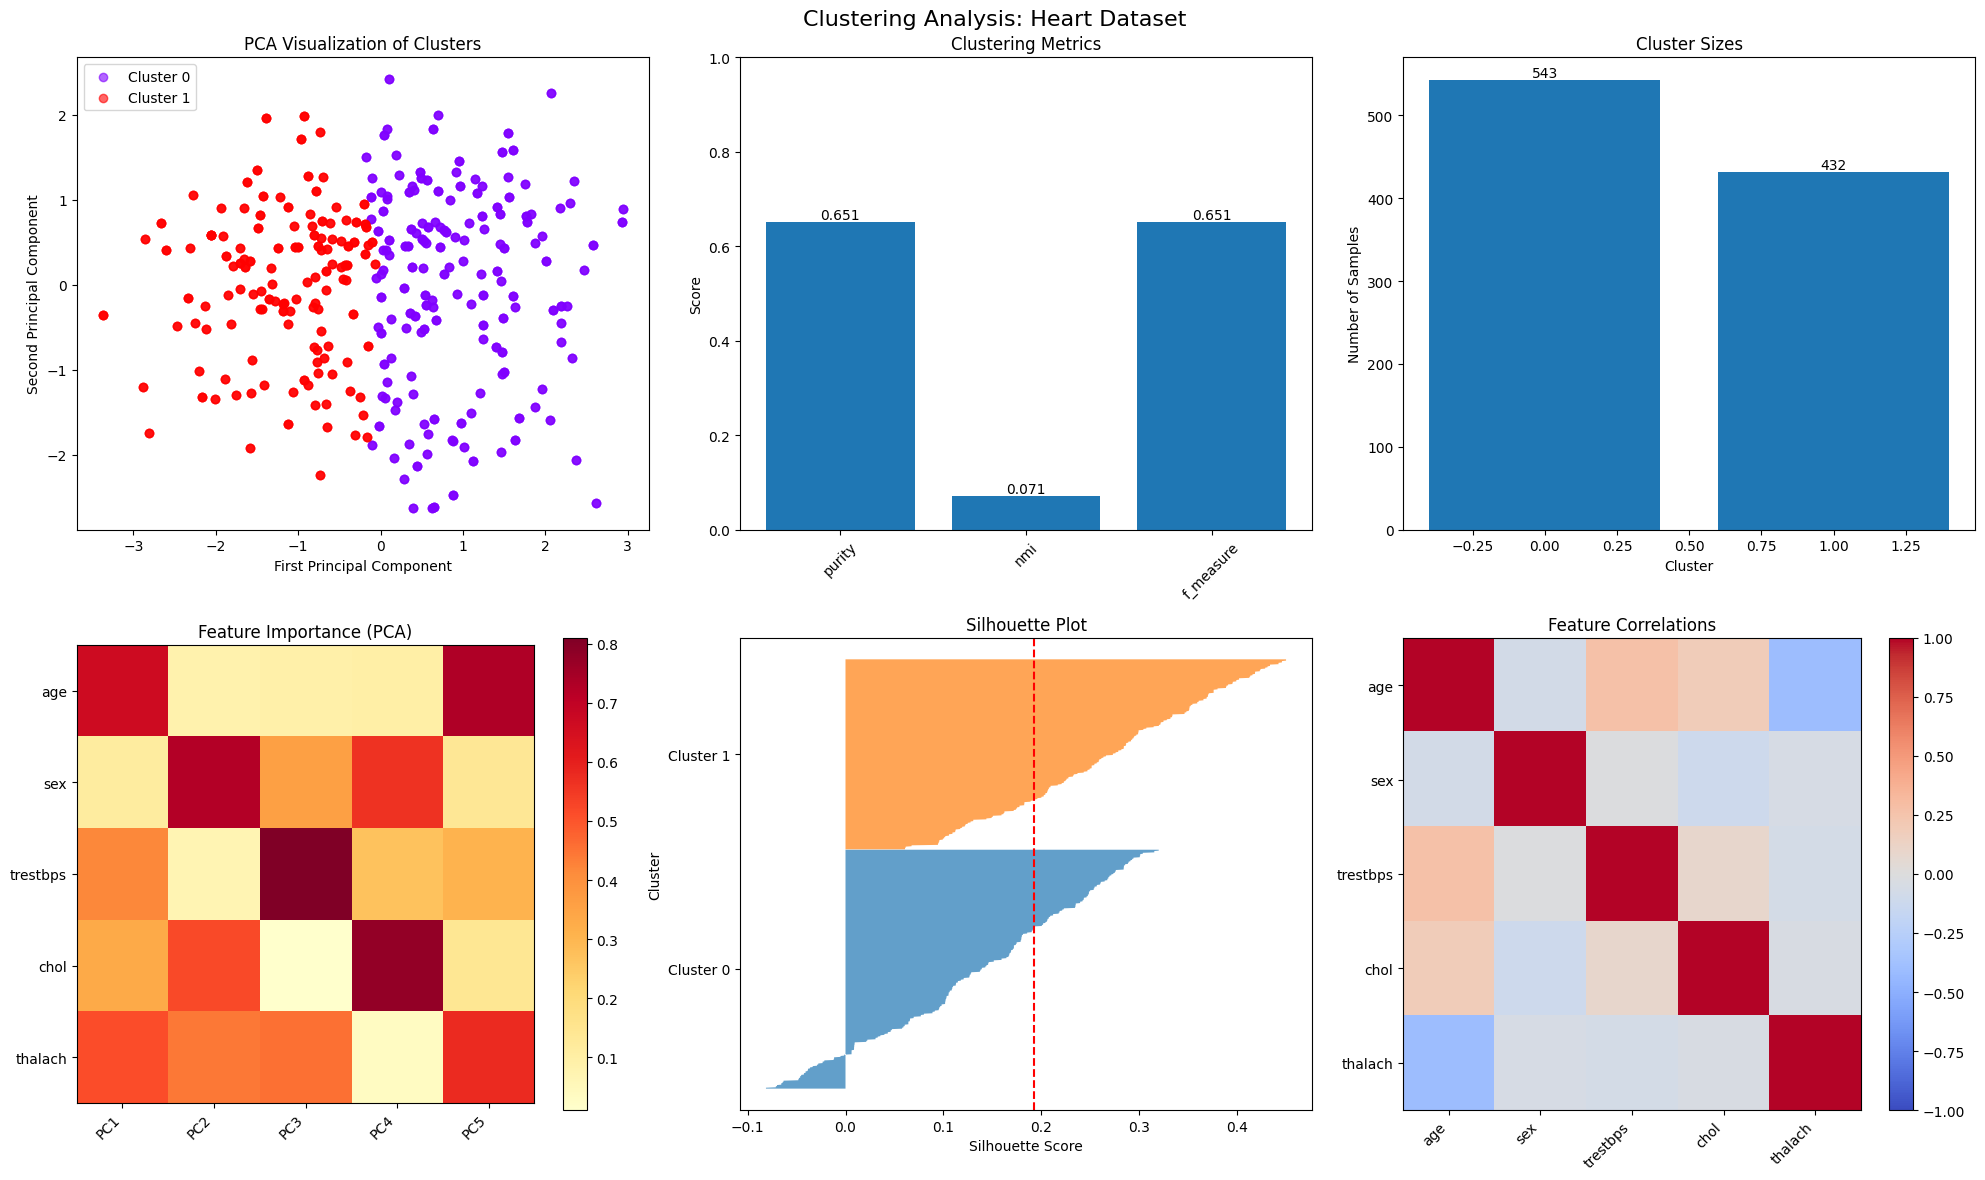

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score, silhouette_samples
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess():
    # Load datasets
    cardio_df = pd.read_csv('/content/drive/MyDrive/AJS/cardio_train.csv', sep=';')
    heart_df = pd.read_csv('/content/drive/MyDrive/AJS/heart.csv')

    # Display original data counts
    print("Original Cardio Data Count:", len(cardio_df))
    print("Original Heart Data Count:", len(heart_df))

    # Normalize gender column
    cardio_df['gender'] = cardio_df['gender'].replace({1: 0, 2: 1})

    # Remove outliers using IQR method
    def remove_outliers(df, features):
        for feature in features:
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
        return df

    cardio_df['age'] = cardio_df['age'] / 365.25  # Convert days to years
    cardio_df['BMI'] = cardio_df['weight'] / ((cardio_df['height'] / 100) ** 2)

    cardio_features_for_outliers = ['age', 'BMI', 'ap_hi', 'ap_lo']
    heart_features_for_outliers = ['age', 'trestbps', 'chol', 'thalach']

    cardio_df = remove_outliers(cardio_df, cardio_features_for_outliers)
    heart_df = remove_outliers(heart_df, heart_features_for_outliers)

    cardio_df.drop(columns=['height', 'weight'], inplace=True)

    # Select relevant features for clustering
    cardio_features = ['age', 'gender', 'BMI', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
    heart_features = ['age', 'sex', 'trestbps', 'chol', 'thalach']

    # Standardize the features
    scaler = StandardScaler()
    cardio_scaled = scaler.fit_transform(cardio_df[cardio_features])
    heart_scaled = scaler.fit_transform(heart_df[heart_features])

    return cardio_scaled, heart_scaled, cardio_df, heart_df, cardio_features, heart_features

def fine_tune_kmeans(data, param_grid):
    best_model = None
    best_score = -np.inf
    best_params = None

    for n_clusters in param_grid['n_clusters']:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)
        score = normalized_mutual_info_score(labels, labels)  # NMI as a scoring metric

        if score > best_score:
            best_score = score
            best_model = kmeans
            best_params = {'n_clusters': n_clusters}

    return best_model, best_params

def calculate_purity(true_labels, predicted_labels):
    contingency = contingency_matrix(true_labels, predicted_labels)
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

def calculate_nmi(true_labels, predicted_labels):
    return normalized_mutual_info_score(true_labels, predicted_labels)

def calculate_f_measure(true_labels, predicted_labels):
    unique_true = np.unique(true_labels)
    f1_scores = []

    for label in unique_true:
        true_binary = (true_labels == label).astype(int)
        pred_binary = (predicted_labels == label).astype(int)
        f1_scores.append(f1_score(true_binary, pred_binary))

    return np.mean(f1_scores)

def evaluate_clustering(predicted_labels, true_labels):
    metrics = {
        'purity': calculate_purity(true_labels, predicted_labels),
        'nmi': calculate_nmi(true_labels, predicted_labels),
        'f_measure': calculate_f_measure(true_labels, predicted_labels)
    }
    return metrics

def visualize_clustering_results(data, labels, title, metrics, feature_names=None):
    """
    Create comprehensive visualizations for clustering results
    """
    # Remove seaborn style dependency
    plt.style.use('default')  # Use matplotlib default style
    fig = plt.figure(figsize=(20, 12))

    # 1. PCA visualization of clusters
    ax1 = plt.subplot(231)
    visualize_clusters_pca(data, labels, ax1)
    ax1.set_title('PCA Visualization of Clusters')

    # 2. Metrics visualization
    ax2 = plt.subplot(232)
    visualize_metrics(metrics, ax2)
    ax2.set_title('Clustering Metrics')

    # 3. Cluster sizes
    ax3 = plt.subplot(233)
    visualize_cluster_sizes(labels, ax3)
    ax3.set_title('Cluster Sizes')

    # 4. Feature importance using PCA
    ax4 = plt.subplot(234)
    visualize_feature_importance(data, ax4, feature_names)
    ax4.set_title('Feature Importance (PCA)')

    # 5. Silhouette plot
    ax5 = plt.subplot(235)
    visualize_silhouette(data, labels, ax5)
    ax5.set_title('Silhouette Plot')

    # 6. Feature correlations
    ax6 = plt.subplot(236)
    visualize_feature_correlations(data, ax6, feature_names)
    ax6.set_title('Feature Correlations')

    # Main title
    plt.suptitle(f'Clustering Analysis: {title}', fontsize=16)
    plt.tight_layout()
    return fig

def visualize_clusters_pca(data, labels, ax):
    """
    Visualize clusters using PCA for dimensionality reduction
    """
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)

    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        mask = labels == label
        ax.scatter(data_2d[mask, 0], data_2d[mask, 1], c=[color], label=f'Cluster {label}', alpha=0.6)

    ax.legend()
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')

def visualize_metrics(metrics, ax):
    """
    Visualize clustering evaluation metrics
    """
    metrics_names = list(metrics.keys())
    metrics_values = list(metrics.values())

    bars = ax.bar(metrics_names, metrics_values)
    ax.set_ylim(0, 1)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    ax.set_ylabel('Score')
    plt.setp(ax.get_xticklabels(), rotation=45)

def visualize_cluster_sizes(labels, ax):
    """
    Visualize the size of each cluster
    """
    unique_labels, counts = np.unique(labels, return_counts=True)

    bars = ax.bar(unique_labels, counts)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of Samples')

def visualize_feature_importance(data, ax, feature_names=None):
    """
    Visualize feature importance using PCA explained variance ratio
    """
    pca = PCA()
    pca.fit(data)

    explained_variance_ratio = pca.explained_variance_ratio_
    components = np.abs(pca.components_)

    if feature_names is None:
        feature_names = [f'Feature {i+1}' for i in range(data.shape[1])]

    # Plot feature importance heatmap
    im = ax.imshow(components.T, cmap='YlOrRd')

    # Add labels
    ax.set_xticks(np.arange(len(explained_variance_ratio)))
    ax.set_yticks(np.arange(len(feature_names)))
    ax.set_xticklabels([f'PC{i+1}' for i in range(len(explained_variance_ratio))])
    ax.set_yticklabels(feature_names)

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Add colorbar
    plt.colorbar(im, ax=ax)

def visualize_silhouette(data, labels, ax):
    """
    Visualize silhouette scores for clusters
    """
    silhouette_vals = silhouette_samples(data, labels)
    y_ticks = []
    y_lower, y_upper = 0, 0

    for i in range(len(np.unique(labels))):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()

        y_upper += len(cluster_silhouette_vals)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0,
                        cluster_silhouette_vals,
                        alpha=0.7)

        y_ticks.append((y_lower + y_upper) / 2)
        y_lower = y_upper

    ax.set_xlabel('Silhouette Score')
    ax.set_ylabel('Cluster')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'Cluster {i}' for i in range(len(y_ticks))])
    ax.axvline(x=np.mean(silhouette_vals), color='red', linestyle='--')

def visualize_feature_correlations(data, ax, feature_names=None):
    """
    Visualize correlations between features
    """
    if feature_names is None:
        feature_names = [f'Feature {i+1}' for i in range(data.shape[1])]

    corr_matrix = np.corrcoef(data.T)
    im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

    # Add labels
    ax.set_xticks(np.arange(len(feature_names)))
    ax.set_yticks(np.arange(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.set_yticklabels(feature_names)

    # Add colorbar
    plt.colorbar(im, ax=ax)

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    cardio_scaled, heart_scaled, cardio_df, heart_df, cardio_features, heart_features = load_and_preprocess()

    # Fine-tune K-Means for both datasets
    print("Fine-tuning K-Means...")
    cardio_param_grid = {'n_clusters': range(2, 10)}
    heart_param_grid = {'n_clusters': range(2, 10)}

    best_cardio_model, best_cardio_params = fine_tune_kmeans(cardio_scaled, cardio_param_grid)
    best_heart_model, best_heart_params = fine_tune_kmeans(heart_scaled, heart_param_grid)

    cardio_clusters = best_cardio_model.labels_
    heart_clusters = best_heart_model.labels_

    # Evaluate clustering
    print("Evaluating clustering results...")
    cardio_metrics = evaluate_clustering(cardio_clusters, cardio_df['cardio'])
    heart_metrics = evaluate_clustering(heart_clusters, heart_df['target'])

    print("\nCardio Evaluation Metrics:")
    print(pd.DataFrame([cardio_metrics]))
    print("Best Cardio K-Means Params:", best_cardio_params)

    print("\nHeart Evaluation Metrics:")
    print(pd.DataFrame([heart_metrics]))
    print("Best Heart K-Means Params:", best_heart_params)

    # Create visualizations
    print("\nCreating visualizations...")

    # Cardio dataset visualizations
    cardio_fig = visualize_clustering_results(
        cardio_scaled,
        cardio_clusters,
        "Cardio Dataset",
        cardio_metrics,
        cardio_features
    )
    cardio_fig.savefig('cardio_clustering_results.png', dpi=300, bbox_inches='tight')

    # Heart dataset visualizations
    heart_fig = visualize_clustering_results(
        heart_scaled,
        heart_clusters,
        "Heart Dataset",
        heart_metrics,
        heart_features
    )
    heart_fig.savefig('heart_clustering_results.png', dpi=300, bbox_inches='tight')

    plt.show()

if __name__ == "__main__":
    main()
